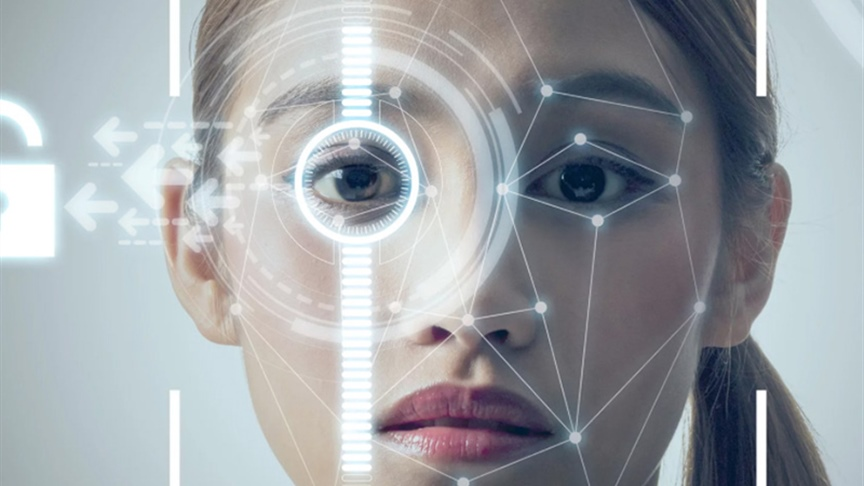

In [1]:
from IPython.display import Image
import os
Image('../input/cvcvcv/CV.jpeg')

# **MNIST-Digit Recognizer-Deep learning for computer vision**

In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cvcvcv/CV.jpeg
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# **Introduction to convnets**
密集連接層和卷積層之間的根本區別在於：Dense層在其輸入特徵空間中學習全局模式（例如，對於 MNIST 數字，模式涉及所有像素），而卷積層學習局部模式，在圖像的情況下，在輸入的小 2D 窗口中發現的模式。

**convnets 提供了兩個有趣的特性：**

1.他們學習的模式是平移不變的：在學習圖片右下角的某個模式後，卷積神經網絡可以在任何地方識別它：例如，在左上角。如果一個密集連接的模型出現在一個新的位置，它就必須重新學習該模式。這使得 convnets 數據在處理圖像時更加高效（因為視覺世界基本上是平移不變的）：它們需要更少的訓練樣本來學習具有泛化能力的表示。

2.他們可以學習模式的空間層次結構。第一個卷積層將學習小的局部模式，例如邊緣，第二個卷積層將學習由第一層的特徵組成的更大的模式，依此類推。這允許 convnets 有效地學習越來越複雜和抽象的視覺概念——因為視覺世界基本上是空間層次的。

# **MNIST_Data**

In [3]:
train=pd.read_csv('../input/digit-recognizer/train.csv')
test=pd.read_csv('../input/digit-recognizer/test.csv')
sample=pd.read_csv('../input/digit-recognizer/sample_submission.csv')

In [4]:
x_train=train.iloc[:,1:]
y_train=train['label']
print(x_train.shape)

(42000, 784)


In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.2)

* 在訓練之前，我們將通過將數據重塑為模型期望的形狀並對其進行縮放來預處理數據，以便所有值都在[0, 1]區間內。以前，我們的訓練圖像存儲在(60000, 28, 28)類型uint8為[0, 255]區間的形狀數組中。我們將其轉換為一個值在 0 到 1 之間float32的形狀數組(60000, 28 * 28)。

In [6]:
x_train=x_train/255
x_test=x_test/255
test=test/255

In [7]:
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
test=test.astype('float32')

In [8]:
x_train=x_train.values.reshape(-1,28,28,1)
x_test=x_test.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

* 讓我們來看看前8筆DATA轉換成圖片後會長怎麼樣

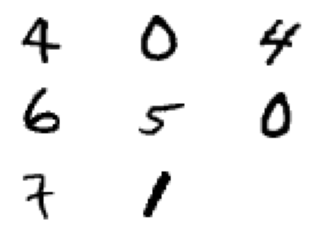

In [9]:
import matplotlib.pyplot as plt
for i in range(8):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i],cmap=plt.cm.binary)
    plt.axis('off')

# **Ready to train**

In [10]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [11]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]

# **Data_augmentation**

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)
datagen.fit(x_train)

# **What we use**
* **Convolution strides**:Using stride 2 means the width and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects). 

* **The max-pooling operation**: That’s the role of max pooling: to aggressively downsample feature maps, much like strided convolutions.

* **BatchNormalization**:Normalization is a broad category of methods that seek to make different samples seen by a machine-learning model more similar to each other, which helps the model learn and generalize well to new data. 

In [13]:
inputs=keras.Input(shape=(28,28,1))
x=inputs
x=keras.layers.Conv2D(filters=64,kernel_size=3,strides=2,padding='same',activation='relu')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Dropout(0.2)(x)
x=keras.layers.MaxPool2D(pool_size=2)(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Dropout(0.2)(x)
x=keras.layers.Conv2D(filters=64,kernel_size=4,strides=2,padding='same',activation='relu')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.MaxPool2D(pool_size=2)(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Conv2D(filters=128,kernel_size=5,strides=2,padding='same',activation='relu')(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(256, activation = "relu")(x)
x=keras.layers.Dropout(0.5)(x)
outputs=keras.layers.Dense(10,activation='softmax')(x)
model=keras.Model(inputs=inputs,outputs=outputs)



In [14]:
model.compile(optimizer='rmsprop',loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [15]:
history=model.fit(x_train,y_train,epochs=5,batch_size=86,validation_data = (x_test,y_test),callbacks=callbacks_list)

Epoch 1/5
391/391 [==============================] - 25s 61ms/step - loss: 0.5035 - accuracy: 0.8387 - val_loss: 2.9313 - val_accuracy: 0.3090
Epoch 2/5
391/391 [==============================] - 22s 57ms/step - loss: 0.0962 - accuracy: 0.9702 - val_loss: 0.0885 - val_accuracy: 0.9730
Epoch 3/5
391/391 [==============================] - 22s 56ms/step - loss: 0.0679 - accuracy: 0.9810 - val_loss: 0.0838 - val_accuracy: 0.9773
Epoch 4/5
391/391 [==============================] - 22s 56ms/step - loss: 0.0555 - accuracy: 0.9836 - val_loss: 0.0584 - val_accuracy: 0.9824
Epoch 5/5
391/391 [==============================] - 22s 57ms/step - loss: 0.0497 - accuracy: 0.9848 - val_loss: 0.0733 - val_accuracy: 0.9796


In [16]:
result=model.predict(test)
result=np.argmax(result,axis=1)
result=pd.Series(result,name='Label')

In [17]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),result],axis = 1)

submission.to_csv("cnn_mnist.csv",index=False)